People always ask: "can you randomize several times and use the proportion of selection, instead of
just one randomization"?

Let's try to figure this out.

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


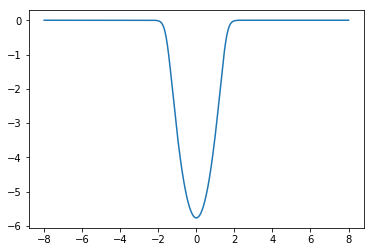

In [38]:
import numpy as np
import regreg.api as rr
import seaborn as sns
%matplotlib inline
%load_ext rpy2.ipython


import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm

from selection.distributions.discrete_family import discrete_family

ntries, sigma, q = 21, 1, 0.3

def algorithm(Z, ntries=ntries, q=q):
    
    proportion = 0
    for _ in range(ntries):
        proportion += ((Z + sigma * np.random.standard_normal() > 2) +
                       (Z + sigma * np.random.standard_normal() < -2)) > 0

    proportion /= ntries
    return proportion > q

Z = np.linspace(-8, 8, 1001)
def fit_algorithm(algorithm, B=5000, ntries=ntries, q=q, Zval=Z, link='logit'):
    
    Z = np.random.standard_normal(B) * 2
    Z = np.hstack([Z, 
                   np.random.standard_normal(B), 
                   np.random.standard_normal(B) * 3, 
                   np.random.standard_normal(B) * 0.5])

    Y = np.array([algorithm(z, ntries=ntries, q=q) for z in Z])

    %R -i Y,Z,Zval 
    %R Z = as.numeric(Z*1)
    if link == 'probit':
        %R M2 = glm(Y ~ poly(Z, 2), family=binomial(link=probit))
    else:
        %R M2 = glm(Y ~ poly(Z, 2), family=binomial(link=logit))

    %R W = predict(M2, newdata=data.frame(Z=Zval), type='link')
    W = %R W
    if link == 'probit':
        return scipy.stats.norm.cdf(W) 
    else:
        return np.exp(W) / (1 + np.exp(W))

def simulate(ntries=ntries, sigma=sigma, truth=0):
               
    while True:
        Z = np.random.standard_normal() + truth
        if algorithm(Z, ntries, q=q):
            return Z

Z = np.linspace(-8, 8, 1001)
W1 = fit_algorithm(algorithm, ntries=ntries, q=q, Zval=Z)
plt.plot(Z, np.log(W1))
selective_law1 = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))


def pivot1(z, truth=0):
    return 1 - selective_law1.cdf(truth, z)



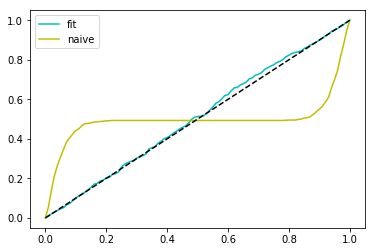

In [39]:
P0 = []

for _ in range(1000):
    P0.append((pivot1(simulate()),
              1 - scipy.stats.norm.cdf(simulate())))
P0 = np.array(P0)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(P0[:,0])(U), 'c', label='fit')
plt.plot(U, sm.distributions.ECDF(P0[:,1])(U), 'y', label='naive')

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()

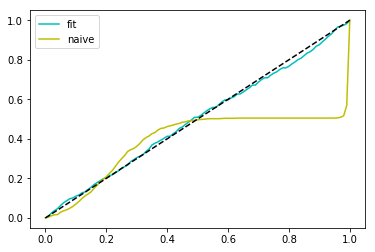

In [40]:
PA = []
truth = 1
for _ in range(1000):
    PA.append((pivot1(simulate(truth=truth), truth=truth),
               1 - scipy.stats.norm.cdf(simulate() - 1)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'c', label='fit')
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'y', label='naive')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')

In [41]:
Z0 = np.linspace(-2,2,501)

LU1 = []
for z in Z0:
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    LU1.append(selective_law.equal_tailed_interval(z))
LU1 = np.array(LU1)

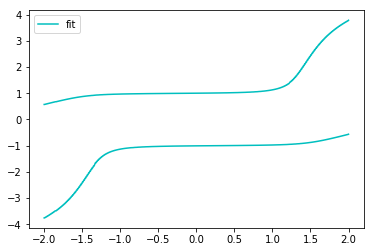

In [42]:
plt.plot(Z0, LU1[:,0], 'c', label='fit')
plt.plot(Z0, LU1[:,1], 'c')
plt.legend()

In [43]:
coverage, ncover, truth = 0, 500, 0
lengths = []
for _ in range(ncover):
    z = simulate(truth=truth)
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    L, U = selective_law.equal_tailed_interval(z)
    coverage += (L < truth) * (U > truth)
    lengths.append(U-L)
    
coverage / ncover, np.mean(lengths), np.std(lengths)

(0.958, 3.7274170418641295, 0.7657363093811798)

In [44]:
coverage, ncover, truth = 0, 500, 2.5
lengths = []
for _ in range(ncover):
    z = simulate(truth=truth)
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    L, U = selective_law.equal_tailed_interval(z)
    coverage += (L < truth) * (U > truth)
    lengths.append(U-L)
    
coverage / ncover, np.mean(lengths), np.std(lengths)

(0.958, 4.343503877556766, 0.3361883508241731)

In [45]:
coverage, ncover, truth = 0, 500, -1.
lengths = []
for _ in range(ncover):
    z = simulate(truth=truth)
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    L, U = selective_law.equal_tailed_interval(z)
    coverage += (L < truth) * (U > truth)
    lengths.append(U-L)
    
coverage / ncover, np.mean(lengths), np.std(lengths)

(0.952, 4.041243863712215, 0.6405537900215537)

# Increasing number of tries

In [46]:
ntries, sigma, q = 41, 0.5, 0.65
Z = np.linspace(-8, 8, 1001)

def pivot(z, truth=0):
    return 1 - selective_law.cdf(truth, z)

def pivot0(z, truth=0):
    return 1 - selective_law0.cdf(truth, z)

def algorithm(Z, ntries=ntries, q=q):
    
    proportion = 0
    for _ in range(ntries):
        proportion += ((Z + sigma * np.random.standard_normal() > 2) + 
                       (Z + sigma * np.random.standard_normal() < -2)) > 0

    proportion /= ntries
    return proportion > q


W1 = fit_algorithm(algorithm, ntries=ntries, q=q, Zval=Z)
selective_law1 = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))

def pivot1(z, truth=0):
    return 1 - selective_law1.cdf(truth, z)

pivot(simulate())


0.9424974699665265

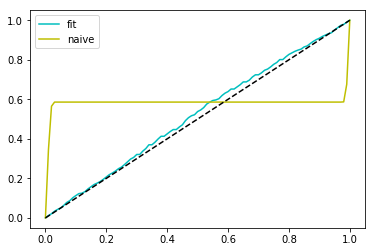

In [51]:
P0 = []
truth = 0.05
for _ in range(1000):
    P0.append((pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth)),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
P0 = np.array(P0)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(P0[:,0])(U), 'c', label='fit')
plt.plot(U, sm.distributions.ECDF(P0[:,1])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()

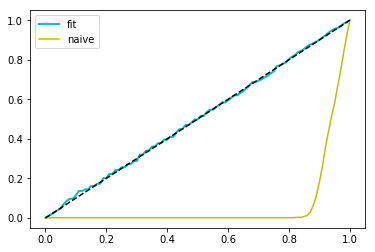

In [52]:
truth = -1
PA = []

for _ in range(1000):
    PA.append((pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'c', label='fit', linewidth=2)
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()


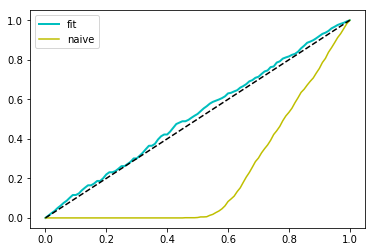

In [53]:
truth = -2
PA = []

for _ in range(1000):
    PA.append((pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'c', label='fit', linewidth=2)
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()



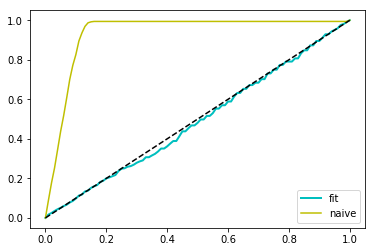

In [54]:
truth = 1
PA = []

for _ in range(1000):
    PA.append((pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'c', label='fit', linewidth=2)
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()



## 